# GRU (Univariate)


In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams["font.family"] = "serif"
% matplotlib inline
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Waseda/4.3 Inaba Zemi/Senior Thesis/Data/"
df = pd.read_csv(path +'df_master_final.csv', index_col='date')
df.index = pd.to_datetime(df.index)

Mounted at /content/drive


## LSTM (Univariate)

In [ ]:
# Importing the libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional, LeakyReLU
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [ ]:
# Some functions to help out with
def plot_predictions(test, predicted, name):
    figure_name = str(name)+'.png'
    plt.plot(test,label='Real Positive Rate')
    plt.plot(predicted,label='Predicted Positive Rate')
    plt.xlabel('Timestamp')
    plt.ylabel('Positive Rate')
    plt.legend()
    plt.savefig(figure_name, dpi=100)

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

### 40 Days

In [ ]:
# Checking for missing values
training_set = np.array(df['Positive\_Rate'][:-40])
training_set = training_set.reshape(-1, 1)
test_set = np.array(df['Positive\_Rate'][-40:])
test_set = test_set.reshape(-1, 1)
limit = len(training_set)

# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

# range within the training data
# Since GRUs store long term memory state, we create a data structure with 10 timesteps and 1 output
# So for each element of training set, we have 10 previous training set elements 
X_train = []
y_train = []
memory_days = 15
for i in range(memory_days, limit):
    X_train.append(training_set_scaled[i-10:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [ ]:
# The GRU architecture
regressor40 = Sequential()

# First GRU layer with Dropout regularisation
regressor40.add(GRU(units=128, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor40.add(LeakyReLU(alpha=0.181818))
regressor40.add(Dropout(0.4))

# Second GRU layer
regressor40.add(GRU(units=256, return_sequences=True))
regressor40.add(LeakyReLU(alpha=0.181818))
regressor40.add(Dropout(0.4))

# Third GRU layer
regressor40.add(GRU(units=128, return_sequences=True))
regressor40.add(LeakyReLU(alpha=0.181818))
regressor40.add(Dropout(0.4))

# Fourth GRU layer
regressor40.add(GRU(units=64))
regressor40.add(LeakyReLU(alpha=0.181818))
regressor40.add(Dropout(0.4))

# The output layer
regressor40.add(Dense(units=1))

# Compiling the RNN
regressor40.compile(optimizer='adam',loss='mean_squared_error')

# Fitting to the training set
history40 = regressor40.fit(X_train,y_train,epochs=500,batch_size=32, validation_split=0.1)

Epoch 1/500
16/16 [==============================] - 10s 179ms/step - loss: 0.0392 - val_loss: 0.0077
Epoch 2/500
16/16 [==============================] - 1s 78ms/step - loss: 0.0105 - val_loss: 0.0118
Epoch 3/500
16/16 [==============================] - 1s 75ms/step - loss: 0.0080 - val_loss: 0.0041
Epoch 4/500
16/16 [==============================] - 1s 75ms/step - loss: 0.0072 - val_loss: 0.0042
Epoch 5/500
16/16 [==============================] - 1s 78ms/step - loss: 0.0072 - val_loss: 0.0031
Epoch 6/500
16/16 [==============================] - 1s 78ms/step - loss: 0.0057 - val_loss: 0.0026
Epoch 7/500
16/16 [==============================] - 1s 78ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 8/500
16/16 [==============================] - 1s 75ms/step - loss: 0.0050 - val_loss: 0.0036
Epoch 9/500
16/16 [==============================] - 1s 75ms/step - loss: 0.0044 - val_loss: 0.0102
Epoch 10/500
16/16 [==============================] - 1s 77ms/step - loss: 0.0044 - val_loss: 0.00

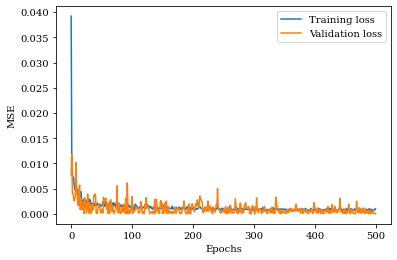

In [ ]:
plt.plot(history40.history['loss'], label='Training loss')
plt.plot(history40.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.savefig('GRU_Uni_40Days_Training.png', dpi=100)

In [ ]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((df[:-40]['Positive\_Rate'],df[-40:]['Positive\_Rate']),axis=0)
inputs = dataset_total[len(dataset_total)- len(test_set) - memory_days:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(memory_days,40+memory_days):
    X_test.append(inputs[i-10:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1], 1))
predicted_positive_rate = regressor40.predict(X_test)
predicted_positive_rate = sc.inverse_transform(predicted_positive_rate)

In [ ]:
pred = predicted_positive_rate.copy()
pred.reshape(40)
date = pd.date_range('2021-11-21', '2021-12-30')
df_pred = pd.DataFrame(pred)
df_pred.index = date
df_pred.index.name = 'date'
df_pred = df_pred.rename(columns={'[0]':'Predicted_Positive\_Rate'})

In [ ]:
test_test = pd.DataFrame(df['Positive\_Rate'][-100:])
train_test = df['Positive\_Rate'][:-40]
pred_test1 = pd.concat([train_test, df_pred])
pred_test = pred_test1[-100:]
# Evaluating our model
test_array = np.array(test_test)
pred_array = np.array(pred_test)
return_rmse(test_array, pred_array)

The root mean squared error is 0.0008487301037893478.


In [ ]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, LeakyReLU
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

# Preparing data
df = pd.read_csv('df_master_final.csv', index_col='date')
df.index = pd.to_datetime(df.index)

# Some functions to help out with
def plot_predictions(test, predicted, name):
    figure_name = str(name)+'.png'
    plt.plot(test,label='Real Positive Rate')
    plt.plot(predicted,label='Predicted Positive Rate')
    plt.xlabel('Timestamp')
    plt.ylabel('Positive Rate')
    plt.legend()
    plt.savefig(figure_name, dpi=100)

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

# LSTM 40 Days

## Preparing data
### Splitting data
training_set = np.array(df['Positive\_Rate'][:-40])
training_set = training_set.reshape(-1, 1)
test_set = np.array(df['Positive\_Rate'][-40:])
test_set = test_set.reshape(-1, 1)
limit = len(training_set)
### Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
### We create a data structure with 15 timesteps and 1 output
X_train = []
y_train = []
memory_days = 15
for i in range(memory_days, limit):
    X_train.append(training_set_scaled[i-10:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
### Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

## The LSTM architecture
regressor40 = Sequential()
### First LSTM layer with Dropout regularisation
regressor40.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor40.add(LeakyReLU(alpha=0.181818))
regressor40.add(Dropout(0.4))
### Second LSTM layer
regressor40.add(LSTM(units=256, return_sequences=True))
regressor40.add(LeakyReLU(alpha=0.181818))
regressor40.add(Dropout(0.4))
### Third LSTM layer
regressor40.add(LSTM(units=128, return_sequences=True))
regressor40.add(LeakyReLU(alpha=0.181818))
regressor40.add(Dropout(0.4))
### Fourth LSTM layer
regressor40.add(LSTM(units=64))
regressor40.add(LeakyReLU(alpha=0.181818))
regressor40.add(Dropout(0.4))
### The output layer
regressor40.add(Dense(units=1))
### Compiling the RNN
regressor40.compile(optimizer='adam',loss='mean_squared_error')
### Fitting to the training set
history40 = regressor40.fit(X_train,y_train,epochs=500,batch_size=32, validation_split=0.1)

## Plot the accuracy preformance results
plt.plot(history40.history['loss'], label='Training loss')
plt.plot(history40.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.savefig('LSTM_Uni_40Days_Training.png', dpi=100)

## Prepare prediction
dataset_total = pd.concat((df[:-40]['Positive\_Rate'],df[-40:]['Positive\_Rate']),axis=0)
inputs = dataset_total[len(dataset_total)- len(test_set) - memory_days:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(memory_days,40+memory_days):
    X_test.append(inputs[i-10:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1], 1))

## Store the prediction results to a dataframe
predicted_positive_rate = regressor40.predict(X_test)
predicted_positive_rate = sc.inverse_transform(predicted_positive_rate)
pred = predicted_positive_rate.copy()
pred.reshape(40)
date = pd.date_range('2021-11-21', '2021-12-30')
df_pred = pd.DataFrame(pred)
df_pred.index = date
df_pred.index.name = 'date'
df_pred = df_pred.rename(columns={'[0]':'Predicted_Positive\_Rate'})

## Evaluating our LSTM model
test_test = pd.DataFrame(df['Positive\_Rate'][-100:])
train_test = df['Positive\_Rate'][:-40]
pred_test1 = pd.concat([train_test, df_pred])
pred_test = pred_test1[-100:]
test_array = np.array(test_test)
pred_array = np.array(pred_test)
return_rmse(test_array, pred_array)

## Visualizing the results for LSTM
plot_predictions(test_test, pred_test, 'LSTM_Uni_40Days')

# GRU 40 Days
## The GRU architecture
regressorG40 = Sequential()

### First GRU layer with Dropout regularisation
regressorG40.add(GRU(units=128, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressorG40.add(LeakyReLU(alpha=0.181818))
regressorG40.add(Dropout(0.4))

### Second GRU layer
regressorG40.add(GRU(units=256, return_sequences=True))
regressorG40.add(LeakyReLU(alpha=0.181818))
regressorG40.add(Dropout(0.4))

### Third GRU layer
regressorG40.add(GRU(units=128, return_sequences=True))
regressorG40.add(LeakyReLU(alpha=0.181818))
regressorG40.add(Dropout(0.4))

### Fourth GRU layer
regressorG40.add(GRU(units=64))
regressorG40.add(LeakyReLU(alpha=0.181818))
regressorG40.add(Dropout(0.4))

### The output layer
regressorG40.add(Dense(units=1))

### Compiling the RNN
regressorG40.compile(optimizer='adam',loss='mean_squared_error')

### Fitting to the training set
historyG40 = regressorG40.fit(X_train,y_train,epochs=500,batch_size=32, validation_split=0.1)

## Plot the accuracy preformance results
plt.plot(historyG40.history['loss'], label='Training loss')
plt.plot(historyG40.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.savefig('GRU_Uni_40Days_Training.png', dpi=100)

## Predicting values
predicted_positive_rateG = regressorG40.predict(X_test)
predicted_positive_rateG = sc.inverse_transform(predicted_positive_rateG)
predG = predicted_positive_rateG.copy()
predG.reshape(40)
predG = pd.date_range('2021-11-21', '2021-12-30')
df_predG = pd.DataFrame(predG)
df_predG.index = date
df_predG.index.name = 'date'
df_predG = df_predG.rename(columns={'[0]':'Predicted_Positive\_Rate'})

## Evaluating our GRU model
test_test = pd.DataFrame(df['Positive\_Rate'][-100:])
train_test = df['Positive\_Rate'][:-40]
pred_test1 = pd.concat([train_test, df_predG])
pred_test = pred_test1[-100:]
test_array = np.array(test_test)
pred_array = np.array(pred_test)
return_rmse(test_array, pred_array)

## Visualizing the results for GRU
plot_predictions(test_test, pred_test, 'GRU_Uni_40Days')

In [ ]:
#pred_test1.to_csv('GRU_Uni_40days.csv')

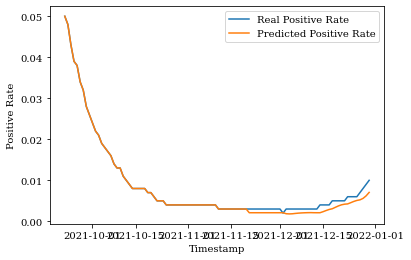

In [ ]:
# Visualizing the results for GRU
plot_predictions(test_test, pred_test, 'GRU_Uni_40Days')

### 20 Days

In [ ]:
# Checking for missing values
training_set = np.array(df['Positive\_Rate'][:-20])
training_set = training_set.reshape(-1, 1)
test_set = np.array(df['Positive\_Rate'][-20:])
test_set = test_set.reshape(-1, 1)
limit = len(training_set)

# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

# range within the training data
# Since GRUs store long term memory state, we create a data structure with 10 timesteps and 1 output
# So for each element of training set, we have 10 previous training set elements 
X_train = []
y_train = []
memory_days = 10
for i in range(memory_days, limit):
    X_train.append(training_set_scaled[i-10:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [ ]:
# Fitting to the training set
# The GRU architecture
regressor1 = Sequential()

# First GRU layer with Dropout regularisation
regressor1.add(GRU(units=128, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor1.add(LeakyReLU(alpha=0.181818))
regressor1.add(Dropout(0.4))

# Second GRU layer
regressor1.add(GRU(units=256, return_sequences=True))
regressor1.add(LeakyReLU(alpha=0.181818))
regressor1.add(Dropout(0.4))

# Third GRU layer
regressor1.add(GRU(units=128, return_sequences=True))
regressor1.add(LeakyReLU(alpha=0.181818))
regressor1.add(Dropout(0.4))

# Fourth GRU layer
regressor1.add(GRU(units=64))
regressor1.add(LeakyReLU(alpha=0.181818))
regressor1.add(Dropout(0.4))

# The output layer
regressor1.add(Dense(units=1))

# Compiling the RNN
regressor1.compile(optimizer='adam',loss='mean_squared_error')

history20 = regressor1.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.1)

Epoch 1/500
17/17 [==============================] - 10s 166ms/step - loss: 0.0366 - val_loss: 0.0095
Epoch 2/500
17/17 [==============================] - 1s 72ms/step - loss: 0.0089 - val_loss: 0.0042
Epoch 3/500
17/17 [==============================] - 1s 74ms/step - loss: 0.0058 - val_loss: 0.0050
Epoch 4/500
17/17 [==============================] - 1s 73ms/step - loss: 0.0058 - val_loss: 0.0015
Epoch 5/500
17/17 [==============================] - 1s 73ms/step - loss: 0.0058 - val_loss: 0.0032
Epoch 6/500
17/17 [==============================] - 1s 72ms/step - loss: 0.0061 - val_loss: 0.0045
Epoch 7/500
17/17 [==============================] - 1s 73ms/step - loss: 0.0054 - val_loss: 0.0028
Epoch 8/500
17/17 [==============================] - 1s 74ms/step - loss: 0.0062 - val_loss: 0.0085
Epoch 9/500
17/17 [==============================] - 1s 73ms/step - loss: 0.0043 - val_loss: 0.0062
Epoch 10/500
17/17 [==============================] - 1s 72ms/step - loss: 0.0052 - val_loss: 0.00

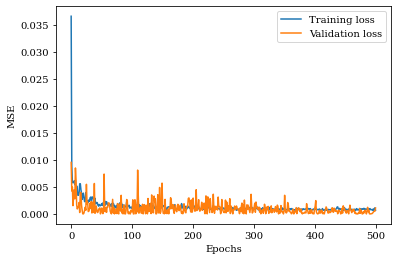

In [ ]:
plt.plot(history20.history['loss'], label='Training loss')
plt.plot(history20.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.savefig('GRU_Uni_20Days_Training.png', dpi=100)

In [ ]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((df[:-20]['Positive\_Rate'],df[-20:]['Positive\_Rate']),axis=0)
inputs = dataset_total[len(dataset_total)- len(test_set) - memory_days:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(memory_days,20+memory_days):
    X_test.append(inputs[i-memory_days:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1], 1))
predicted_positive_rate = regressor1.predict(X_test)
predicted_positive_rate = sc.inverse_transform(predicted_positive_rate)

In [ ]:
pred = predicted_positive_rate.copy()
pred.reshape(20)
date = pd.date_range('2021-12-11', '2021-12-30')
df_pred = pd.DataFrame(pred)
df_pred.index = date
df_pred.index.name = 'date'
df_pred = df_pred.rename(columns={'[0]':'Predicted_Positive\_Rate'})

In [ ]:
test_test = pd.DataFrame(df['Positive\_Rate'][-100:])
train_test = df['Positive\_Rate'][:-20]
pred_test1 = pd.concat([train_test, df_pred])
pred_test = pred_test1[-100:]
# Evaluating our model
test_array = np.array(test_test)
pred_array = np.array(pred_test)
return_rmse(test_array, pred_array)

The root mean squared error is 0.0032901332588569157.


In [ ]:
pred_test1.to_csv("GRU_Uni_20days.csv")

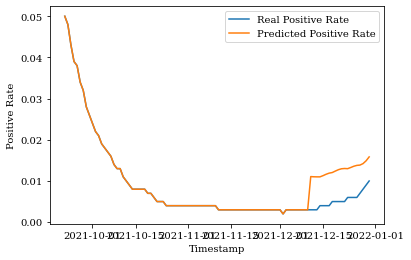

In [ ]:
# Visualizing the results for GRU
plot_predictions(test_test, pred_test, 'GRU_Uni_20Days')

### 80 Days

In [ ]:
# Checking for missing values
training_set = np.array(df['Positive\_Rate'][:-80])
training_set = training_set.reshape(-1, 1)
test_set = np.array(df['Positive\_Rate'][-80:])
test_set = test_set.reshape(-1, 1)
limit = len(training_set)

# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

# range within the training data
# Since GRUs store long term memory state, we create a data structure with 10 timesteps and 1 output
# So for each element of training set, we have 10 previous training set elements 
X_train = []
y_train = []
memory_days = 10
for i in range(memory_days, limit):
    X_train.append(training_set_scaled[i-10:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [ ]:
# Fitting to the training set
# The GRU architecture
regressor2 = Sequential()

# First GRU layer with Dropout regularisation
regressor2.add(GRU(units=128, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor2.add(Dropout(0.4))

# Second GRU layer
regressor2.add(GRU(units=256, return_sequences=True))
regressor2.add(Dropout(0.4))

# Third GRU layer
regressor2.add(GRU(units=128, return_sequences=True))
regressor2.add(Dropout(0.4))

# Fourth GRU layer
regressor2.add(GRU(units=64))
regressor2.add(Dropout(0.4))

# The output layer
regressor2.add(Dense(units=1))

# Compiling the RNN
regressor2.compile(optimizer='adam',loss='mean_squared_error')

historyreg80 = regressor2.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.1)

Epoch 1/500
15/15 [==============================] - 10s 182ms/step - loss: 0.0183 - val_loss: 0.0166
Epoch 2/500
15/15 [==============================] - 1s 74ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 3/500
15/15 [==============================] - 1s 74ms/step - loss: 0.0044 - val_loss: 0.0122
Epoch 4/500
15/15 [==============================] - 1s 73ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 5/500
15/15 [==============================] - 1s 73ms/step - loss: 0.0039 - val_loss: 0.0059
Epoch 6/500
15/15 [==============================] - 1s 74ms/step - loss: 0.0045 - val_loss: 6.2167e-04
Epoch 7/500
15/15 [==============================] - 1s 74ms/step - loss: 0.0035 - val_loss: 8.8022e-04
Epoch 8/500
15/15 [==============================] - 1s 74ms/step - loss: 0.0030 - val_loss: 8.9226e-04
Epoch 9/500
15/15 [==============================] - 1s 73ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 10/500
15/15 [==============================] - 1s 74ms/step - loss: 0.0033 - va

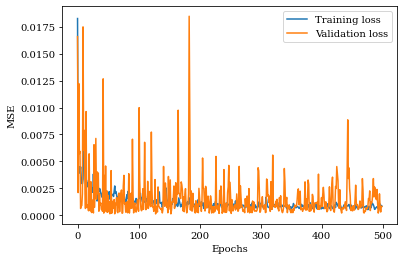

In [ ]:
plt.plot(historyreg80.history['loss'], label='Training loss')
plt.plot(historyreg80.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.savefig('GRU_Uni_80Days_Training.png', dpi=100)

In [ ]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((df[:-80]['Positive\_Rate'],df[-80:]['Positive\_Rate']),axis=0)
inputs = dataset_total[len(dataset_total)- len(test_set) - memory_days:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(memory_days, 80+memory_days):
    X_test.append(inputs[i-memory_days:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_positive_rate = regressor2.predict(X_test)
predicted_positive_rate = sc.inverse_transform(predicted_positive_rate)

In [ ]:
pred = predicted_positive_rate.copy()
pred.reshape(80)
date = pd.date_range('2021-10-12', '2021-12-30')
df_pred = pd.DataFrame(pred)
df_pred.index = date
df_pred.index.name = 'date'
df_pred = df_pred.rename(columns={'[0]':'Predicted_Positive\_Rate'})

In [ ]:
test_test = pd.DataFrame(df['Positive\_Rate'][-100:])
train_test = df['Positive\_Rate'][:-80]
pred_test1 = pd.concat([train_test, df_pred])
pred_test = pred_test1[-100:]
# Evaluating our model
test_array = np.array(test_test)
pred_array = np.array(pred_test)
return_rmse(test_array, pred_array)

The root mean squared error is 0.008384795494336978.


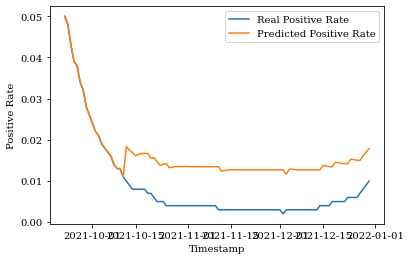

In [ ]:
# Visualizing the results for GRU
plot_predictions(test_test, pred_test, 'GRU_Uni_80Days')